In [1]:
#importation des librairies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer,RobustScaler,MinMaxScaler,StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix,precision_score, recall_score, f1_score
import seaborn as sns
import joblib

In [2]:
def charger_fichier(path):
    ext = path.split(".")[-1]
    if ext in ['csv','txt']:
        data = pd.read_csv(path)
    elif ext in ['xls','xlsx']:
        data = pd.read_excel(path)
    return data

In [3]:
def normalisation(df, method):
    """
    Méthode permettant de normaliser les données quantitatives d'un dataframe
    @params df : Dataframe
    @params method: Entier compris entre 1 et 3
        1 => Utilisation de MinMax
        2 => Utilisation de Z-score
        3 => Utilisation de la méthode robuste (résiste aux valeurs aberrantes)
    """
    df_copy = df.copy()  # Utiliser une copie du DataFrame pour éviter de modifier l'original
    
    if method == 1:
        scaler = MinMaxScaler()
    elif method == 2:
        scaler = StandardScaler()
    else:
        scaler = RobustScaler()
    
    scaled_data = scaler.fit_transform(df_copy.select_dtypes(include=['int', 'float']))
    df_copy.loc[:, df_copy.select_dtypes(include=['int', 'float']).columns] = scaled_data
    return df_copy,scaler

# Exploration des données

In [4]:
df = charger_fichier('donnees_generer_complet_consultations_medicales.xlsx')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1160 entries, 0 to 1159
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Age (en mois)  1160 non-null   float64
 1   Sexe           1160 non-null   object 
 2   Poids (kg)     1160 non-null   float64
 3   Symptômes      1160 non-null   object 
 4   Pathologie     1160 non-null   object 
 5   Traitement     1160 non-null   object 
dtypes: float64(2), object(4)
memory usage: 54.5+ KB


In [6]:
df.head()

,Age (en mois),Sexe,Poids (kg),Symptômes,Pathologie,Traitement
0,420.0,M,80.0,"Tremblements, Sueurs, Anxiété",Hypoglycémie,Donner 15 à 20 g de sucre sous forme de morcea...
1,504.0,F,68.0,"Confusion, Convulsions",Hypoglycémie sévère,Administrer 1 ml/ de glucose 50% en IV lente (...
2,600.0,M,95.0,"Tremblements, Pâleur",Hypoglycémie,Donner 15 à 20 g de sucre sous forme de morcea...
3,336.0,F,60.0,"Fatigue, Léthargie",Hypoglycémie,Donner 15 à 20 g de sucre sous forme de morcea...
4,540.0,M,92.0,"Confusion, Coma",Hypoglycémie sévère,Administrer 1 ml/ de glucose à 50% en IV lente...


In [7]:
df.describe(include='all')

,Age (en mois),Sexe,Poids (kg),Symptômes,Pathologie,Traitement
count,1160.000000,1160,1160.000000,1160,1160,1160
unique,NaN,2,NaN,263,29,146
top,NaN,M,NaN,"Plaques cutanées, diarrhée, démence",Hypoglycémie,Désobstruction du nez par lavage au chlorure d...
freq,NaN,581,NaN,40,40,41
mean,300.815862,NaN,47.144655,NaN,NaN,NaN
std,226.674273,NaN,26.759522,NaN,NaN,NaN
min,2.000000,NaN,3.500000,NaN,NaN,NaN
25%,72.000000,NaN,18.000000,NaN,NaN,NaN
50%,324.000000,NaN,55.750000,NaN,NaN,NaN
75%,468.000000,NaN,70.000000,NaN,NaN,NaN


In [8]:
df.isnull().sum()

Age (en mois)    0
Sexe             0
Poids (kg)       0
Symptômes        0
Pathologie       0
Traitement       0
dtype: int64

# Transformation de la colonne Symptomes en 05 autres colonnes

In [9]:
symptomes = df['Symptômes']

# Diviser les symptômes en colonnes individuelles
for i, symptome in enumerate(symptomes):
    if isinstance(symptome, str):  # Vérifier si la valeur est une chaîne de caractères
        tabs = symptome.split(',')
        for j, tab in enumerate(tabs[:5]):
            df.at[i, f'Symptome_{j + 1}'] = tab.strip()

# Supprimer la colonne "Symptômes" originale
df = df.drop(columns=['Symptômes'])


In [10]:
# Sélectionnez les 5 dernières colonnes
dernieres_colonnes = df.iloc[:, -5:]

# Supprimez les 5 dernières colonnes du DataFrame original
df = df.iloc[:, :-5]

# Insérez les 5 dernières colonnes à la 3e position
position_inserer = 3  # L'index 2 correspond à la 3e position (index de base 0)
for col in dernieres_colonnes.columns:
    df.insert(position_inserer, col, dernieres_colonnes[col])



In [11]:
#Modalités de la variable cible
df.loc[:, 'Pathologie'].unique()

array(['Hypoglycémie', 'Hypoglycémie sévère', 'Reflux gastro-œsophagien',
       'Anémie', 'Amaigrissement', 'Rhinopharyngite', 'Rhinite (rhume)',
       'Sinusite bactérienne', 'Sinusite virale', 'Angine',
       'Bronchite aiguë', 'Trachéite bactérienne', 'Otite externe aiguë',
       'Otite moyenne aiguë (OMA)',
       'Otite moyenne chronique suppurée (OMCS)',
       'Tuberculose pulmonaire', 'Stomatite du  scorbut', 'Paludisme',
       'Onchocercose', 'Rougeole', 'Poliomyélite', 'Anxiété', 'Pellagre',
       'Cystite aiguë', 'Prostatite aiguë', 'Trichomonase', 'Insomnie',
       'Dermatite séborrhéique', 'Furoncle'], dtype=object)

# Suppresion des colonnes inutiles

In [12]:
useless_cols = ['Traitement']
df.drop(useless_cols,axis=1,inplace=True)
df.head()

,Age (en mois),Sexe,Poids (kg),Symptome_5,Symptome_4,Symptome_3,Symptome_2,Symptome_1,Pathologie
0,420.0,M,80.0,NaN,NaN,Anxiété,Sueurs,Tremblements,Hypoglycémie
1,504.0,F,68.0,NaN,NaN,NaN,Convulsions,Confusion,Hypoglycémie sévère
2,600.0,M,95.0,NaN,NaN,NaN,Pâleur,Tremblements,Hypoglycémie
3,336.0,F,60.0,NaN,NaN,NaN,Léthargie,Fatigue,Hypoglycémie
4,540.0,M,92.0,NaN,NaN,NaN,Coma,Confusion,Hypoglycémie sévère


In [13]:
df.isnull().sum()

Age (en mois)       0
Sexe                0
Poids (kg)          0
Symptome_5       1096
Symptome_4        965
Symptome_3        719
Symptome_2        234
Symptome_1          0
Pathologie          0
dtype: int64

In [14]:
df.fillna('Aucun',inplace=True)

In [15]:
df.isnull().sum()

Age (en mois)    0
Sexe             0
Poids (kg)       0
Symptome_5       0
Symptome_4       0
Symptome_3       0
Symptome_2       0
Symptome_1       0
Pathologie       0
dtype: int64

## Comprehension des donnees

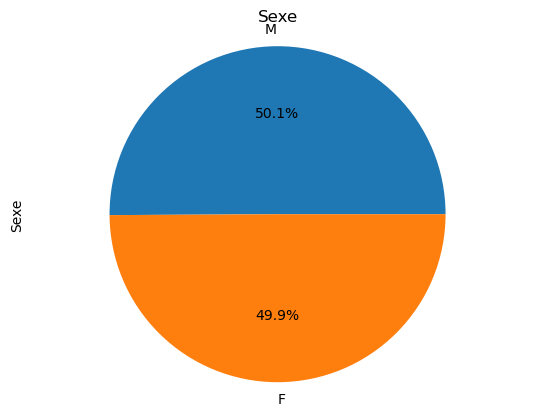

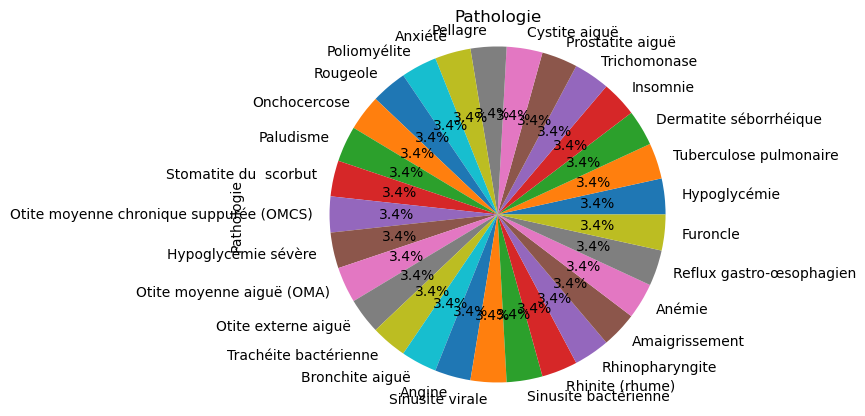

In [16]:
cols_ = ['Sexe','Pathologie']
for var in cols_:
    df[var].value_counts().plot(kind='pie',autopct='%1.1f%%')
    plt.title(var)
    plt.axis('equal')
    plt.show()

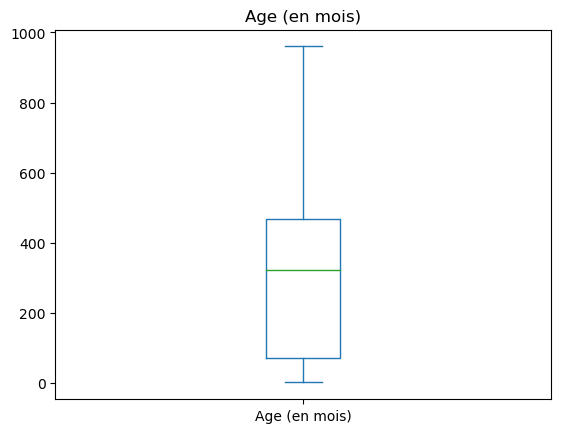

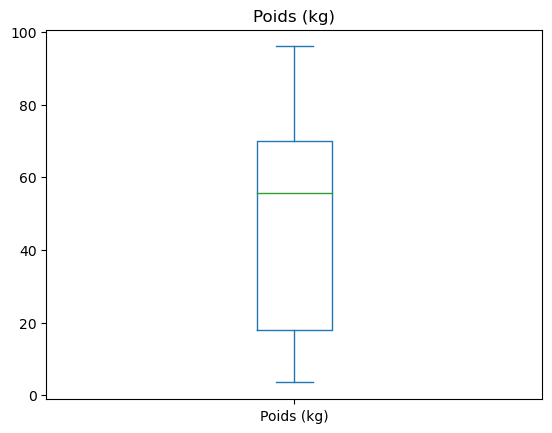

In [17]:
num_vars = ['Age (en mois)','Poids (kg)']

#generer un boxplot pour chaque variable quantitative
for var in num_vars:
    df[var].plot(kind='box')
    plt.title(var)
    plt.show()

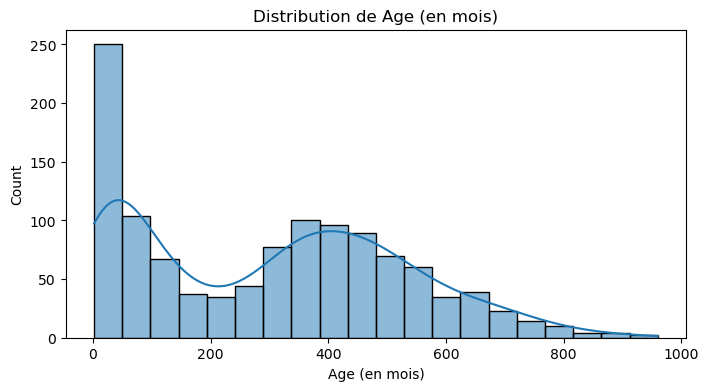

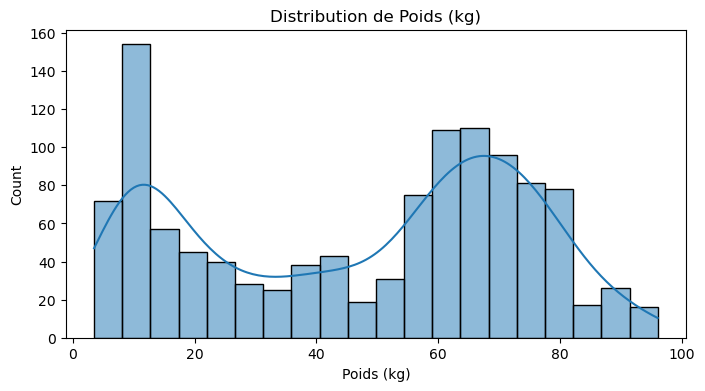

In [18]:
# Distribution des variables numériques
for col in df.select_dtypes(include=['int', 'float']):
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f'Distribution de {col}')
    plt.show()


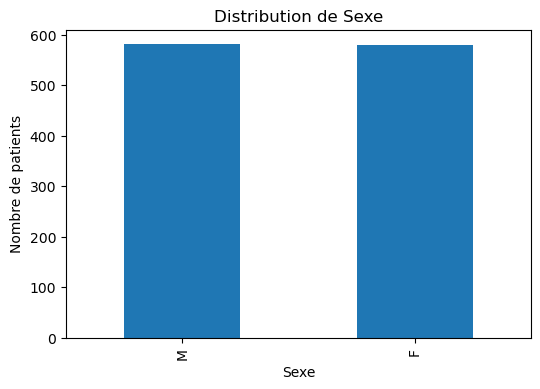

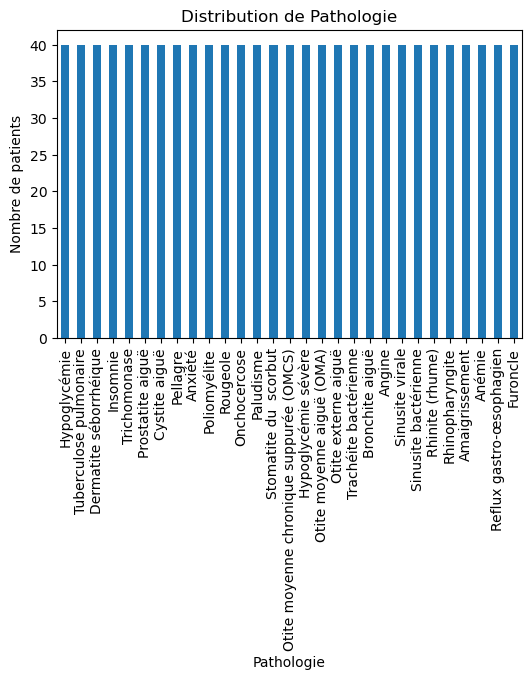

In [19]:
# Distribution des variables catégoriques (par exemple, le sexe)
for col in ['Sexe','Pathologie']:
    plt.figure(figsize=(6, 4))
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Distribution de {col}')
    plt.xlabel(f'{col}')
    plt.ylabel('Nombre de patients')
    plt.show()

## Analyse Bivariée

/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_14157/2151792322.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = df.corr()


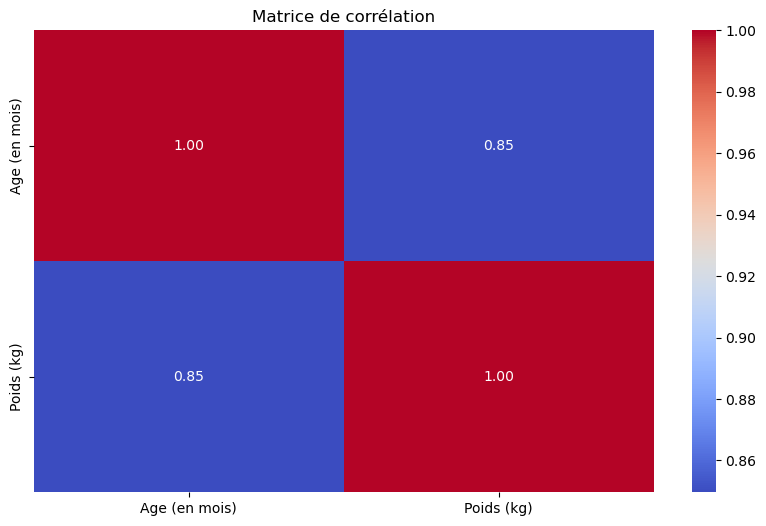

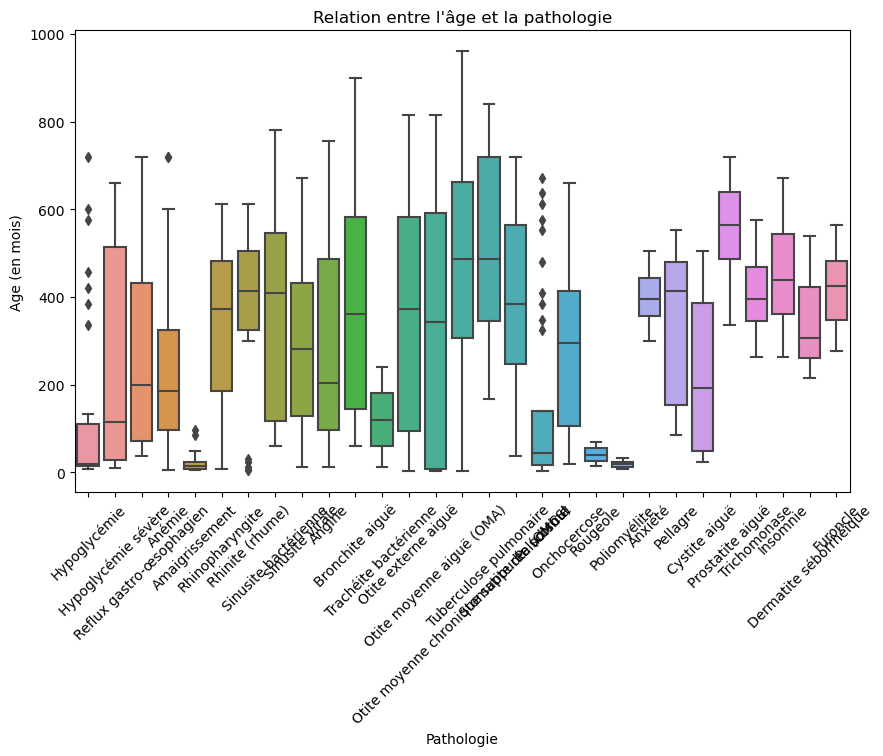

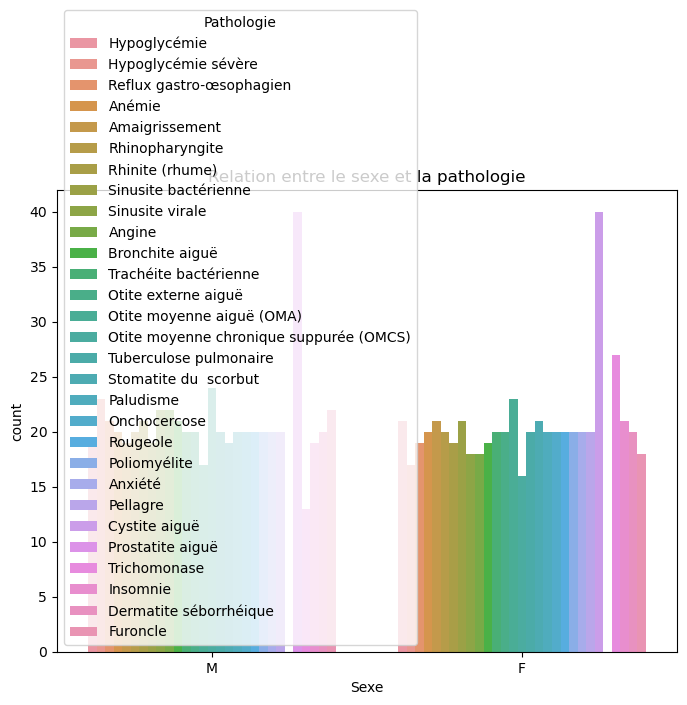

In [20]:
# Matrice de corrélation pour les variables numériques
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matrice de corrélation')
plt.show()

# Relation entre l'âge et la pathologie (exemple)
plt.figure(figsize=(10, 6))
sns.boxplot(x='Pathologie', y='Age (en mois)', data=df)
plt.title('Relation entre l\'âge et la pathologie')
plt.xticks(rotation=45)
plt.show()

# Relation entre deux variables catégoriques (exemple : sexe et pathologie)
plt.figure(figsize=(8, 6))
sns.countplot(x='Sexe', hue='Pathologie', data=df)
plt.title('Relation entre le sexe et la pathologie')
plt.show()

Le coefficient de corrélation positif (0.85) suggère que, en général, à mesure que l'âge en mois augmente, le poids en kg a tendance à augmenter également. Cela signifie qu'il existe une relation linéaire positive entre l'âge et le poids, ce qui est cohérent avec l'idée que les enfants ont tendance à prendre du poids à mesure qu'ils grandissent. Cette corrélation ne signifie pas nécessairement une relation de cause à effet. En d'autres termes, bien que l'âge et le poids soient corrélés, cela ne signifie pas que l'âge cause directement le poids à augmenter. D'autres facteurs peuvent également influencer le poids.

<Axes: xlabel='Age (en mois)', ylabel='Poids (kg)'>

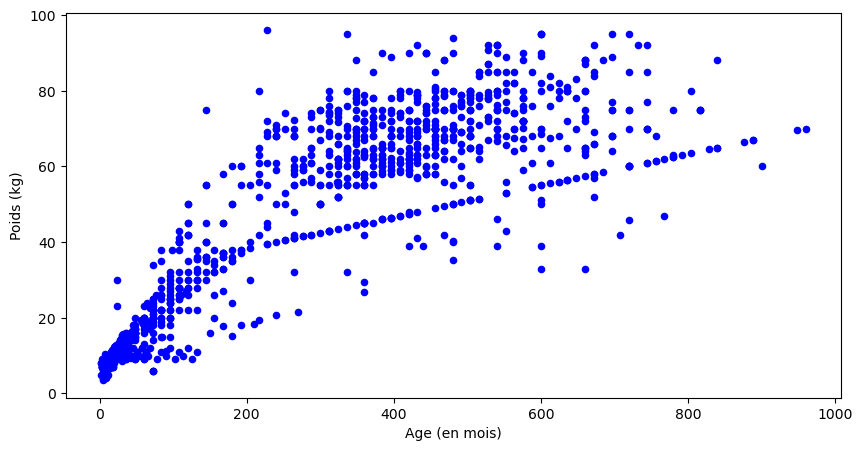

In [21]:
df.plot(x='Age (en mois)',y='Poids (kg)',kind='scatter',figsize =(10,5),c='blue')

In [22]:
df.head()

,Age (en mois),Sexe,Poids (kg),Symptome_5,Symptome_4,Symptome_3,Symptome_2,Symptome_1,Pathologie
0,420.0,M,80.0,Aucun,Aucun,Anxiété,Sueurs,Tremblements,Hypoglycémie
1,504.0,F,68.0,Aucun,Aucun,Aucun,Convulsions,Confusion,Hypoglycémie sévère
2,600.0,M,95.0,Aucun,Aucun,Aucun,Pâleur,Tremblements,Hypoglycémie
3,336.0,F,60.0,Aucun,Aucun,Aucun,Léthargie,Fatigue,Hypoglycémie
4,540.0,M,92.0,Aucun,Aucun,Aucun,Coma,Confusion,Hypoglycémie sévère


/Users/maestro/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:712: UserWarning: Using the countplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


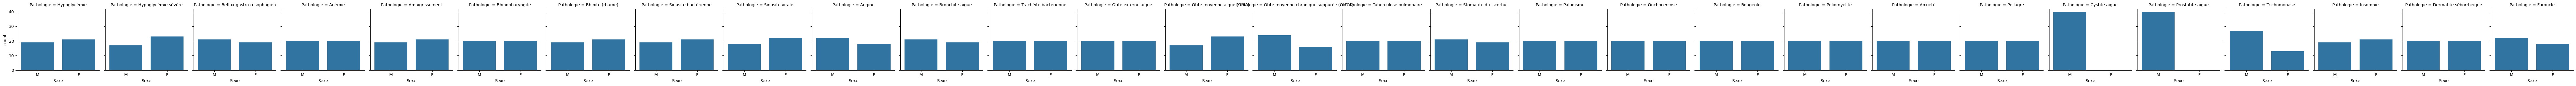

In [23]:
grid = sns.FacetGrid(df,col='Pathologie')
grid.map(sns.countplot,'Sexe')

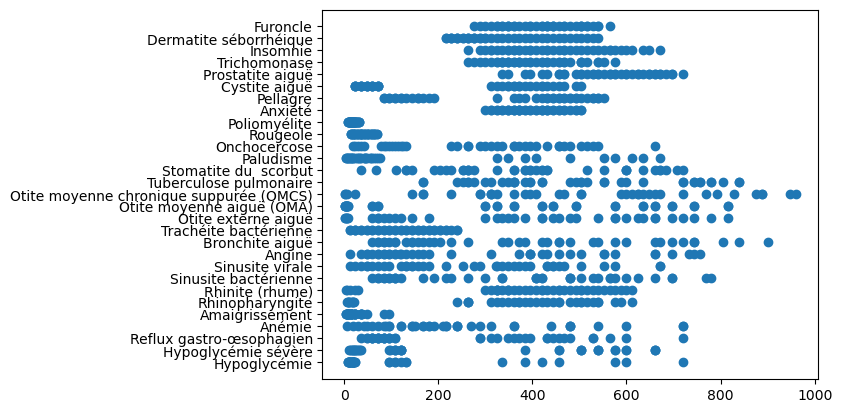

In [24]:
plt.scatter(df['Age (en mois)'],df['Pathologie'])

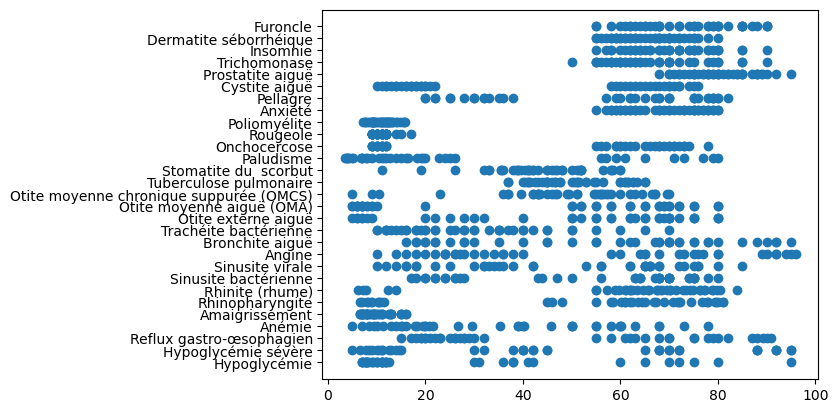

In [25]:
plt.scatter(df['Poids (kg)'],df['Pathologie'])

# Normalisation 

In [26]:

df_normalized,scaler = normalisation(df, method=1)
# Remplacement des colonnes normalisées dans le DataFrame original
df = df_normalized

# Afficher le DataFrame après normalisation
df.head()

,Age (en mois),Sexe,Poids (kg),Symptome_5,Symptome_4,Symptome_3,Symptome_2,Symptome_1,Pathologie
0,0.436326,M,0.827027,Aucun,Aucun,Anxiété,Sueurs,Tremblements,Hypoglycémie
1,0.524008,F,0.697297,Aucun,Aucun,Aucun,Convulsions,Confusion,Hypoglycémie sévère
2,0.624217,M,0.989189,Aucun,Aucun,Aucun,Pâleur,Tremblements,Hypoglycémie
3,0.348643,F,0.610811,Aucun,Aucun,Aucun,Léthargie,Fatigue,Hypoglycémie
4,0.561587,M,0.956757,Aucun,Aucun,Aucun,Coma,Confusion,Hypoglycémie sévère


# Encodage des variables qualitatives

In [27]:
encoder_symptome_5 = LabelBinarizer()
encoder_symptome_4 = LabelBinarizer()
encoder_symptome_3 = LabelBinarizer()
encoder_symptome_2 = LabelBinarizer()
encoder_symptome_1 = LabelBinarizer()
encoder_sexe = LabelBinarizer()
encoder_pathologie = LabelEncoder()


In [28]:
def encodage(data, columns, cible):
    
    #Encodage des variables explicatives qualitative avec LabelBinarizer
    cat_col = list(_ for _ in columns)
    for col in cat_col:
        enc_data = None  # Initialisation de enc_data
        if col == "Symptome_5":
            enc_data = encoder_symptome_5.fit_transform(data.loc[:, col].astype(str))
        elif col == "Symptome_4":
            enc_data = encoder_symptome_4.fit_transform(data.loc[:, col].astype(str))
        elif col == "Symptome_3":
            enc_data = encoder_symptome_3.fit_transform(data.loc[:, col].astype(str))
        elif col == "Symptome_2":
            enc_data = encoder_symptome_2.fit_transform(data.loc[:, col].astype(str))
        elif col == "Symptome_1":
            enc_data = encoder_symptome_1.fit_transform(data.loc[:, col].astype(str))
        elif col == "Sexe":
            enc_data = encoder_sexe.fit_transform(data.loc[:, col].astype(str))

        if enc_data is not None:
            prev_mod = [f"{col}_{mod}" for mod in list(data.loc[:, col].unique())]
            if len(prev_mod) == enc_data.shape[1]:
                data[prev_mod] = enc_data
                data.drop(col, axis=1, inplace=True)
            else:
                data.drop(col, axis=1, inplace=True)
                data[col] = enc_data
            
    #Encodage de la variable cible avec LabelEncoder
    enc_cible = encoder_pathologie.fit_transform(data.loc[:,cible])
    data.drop(cible,axis=1,inplace=True)
    data[cible] = enc_cible
            
    return data
                                            

In [29]:
#Liste des variables categorielles a encoder
cols_to_encoder = df.select_dtypes(include=['object']).columns
cols_to_encoder

Index(['Sexe', 'Symptome_5', 'Symptome_4', 'Symptome_3', 'Symptome_2',
       'Symptome_1', 'Pathologie'],
      dtype='object')

In [30]:
df=encodage(df,cols_to_encoder,'Pathologie')

/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_14157/3502916783.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[prev_mod] = enc_data
/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_14157/3502916783.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data[prev_mod] = enc_data
/var/folders/rd/408jh18j04b0rjlsj8z_718m0000gn/T/ipykernel_14157/3502916783.py:23: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performa

In [31]:
df = df.reindex(sorted(df.columns), axis=1)

In [32]:
# Exportez les données traitées vers un fichier CSV
df.to_csv('donnees_traites.csv', index=False)


In [33]:
prepared_data = charger_fichier('donnees_traites.csv')

In [34]:
prepared_data.shape

(1160, 273)

## Nombres de pathologies présentent

In [35]:
len(prepared_data.loc[:, 'Pathologie'].unique())

29

In [36]:
prepared_data

,Age (en mois),Pathologie,Poids (kg),Sexe,Symptome_1_Anxiété,Symptome_1_Balanite,Symptome_1_Bouquets de vésicules,Symptome_1_Brûlures mictionnelles,Symptome_1_Brûlures épigastriques,Symptome_1_Cauchemars,...,Symptome_5_douleurs péniennes,Symptome_5_douleurs périnéales,Symptome_5_douleurs rectales,Symptome_5_douleurs urétrales,Symptome_5_fièvre légère,Symptome_5_fièvre modérée,Symptome_5_retention d'urine,Symptome_5_toux importante,Symptome_5_toux productive,Symptome_5_toux sèche
0,0.436326,8,0.827027,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.524008,9,0.697297,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.624217,8,0.989189,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.348643,8,0.610811,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.561587,9,0.956757,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1155,0.235908,23,0.437838,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1156,0.336117,24,0.567568,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1157,0.423800,23,0.654054,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1158,0.448852,24,0.675676,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Separation des donnees en Train et Test

In [37]:
y = prepared_data['Pathologie']
X = prepared_data.drop('Pathologie',axis=1)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)

In [39]:
X_train.shape

(928, 272)

In [40]:
X_test.shape


(232, 272)

## Recherche du meilleur estimateur avec ses parametres avec GridSearchCv

In [41]:
models = parametres_grid = [
    ('K-Nearest Neighbors (KNN)', KNeighborsClassifier(), {
        "n_neighbors": np.arange(1, 20),
        "metric": ["euclidean", "manhattan"],
        "weights": ["uniform", "distance"]
    }),

    ('Decision Tree', DecisionTreeClassifier(), {
        "criterion": ["gini", "entropy"],
        "splitter": ["best", "random"],
        "max_depth": [None, 2, 4, 6, 8, 10],
        "min_samples_split": np.arange(2, 10, 1),
        "min_samples_leaf": list(range(1, 10, 1))
    }),

    ('Random Forest', RandomForestClassifier(), {
        "criterion": ["gini", "entropy"],
        "n_estimators": [50, 100, 150],
        "max_features": ["auto", "sqrt", "log2"],
        "max_depth": [None, 1, 3, 5, 7, 9]
    }),

    ('Bagging', BaggingClassifier(), {
        "n_estimators": [10, 20, 30],
        "max_samples": np.arange(0.1, 1.1, 0.1),
        "max_features": np.arange(0.1, 1.1, 0.1)
    }),

    ('Logistic Regression', LogisticRegression(max_iter=10000, multi_class='multinomial'), {
        "C": np.logspace(-3, 3, 7),
        "penalty": ["l1", "l2"],
        "solver": ["newton-cg", "lbfgs", "liblinear", "sag", "saga"]
    }),

    ('Naive Bayes', MultinomialNB(), { 
        "alpha": [0.1, 0.5, 1.0], 
        "fit_prior": [True, False]  
    }),

]


model_names = []
best_parametre = []
score = []
bons_model  = []
# Boucle pour tester chaque modèle avec GridSearchCV
for model_name, model, param_grid in models:
    grid_search = GridSearchCV(model, param_grid, cv=5,scoring='accuracy',n_jobs=-1)
    grid_search.fit(X_train, y_train)
    grid_score = grid_search.score(X_test, y_test)
    score.append(grid_score)
    model_names.append(model_name)
    best_parametre.append(grid_search.best_params_)
    bons_model.append(grid_search)
    

/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(
/Users/maestro/anaconda3/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as 

In [42]:
model_search = pd.DataFrame({"Algorithme": model_names, "Meilleur parametres": best_parametre, "score" : score, "model_al" : bons_model})


In [43]:
model_search.sort_values(by='score', ascending=False)

,Algorithme,Meilleur parametres,score,model_al
2,Random Forest,"{'criterion': 'gini', 'max_depth': None, 'max_...",0.948276,"GridSearchCV(cv=5, estimator=RandomForestClass..."
0,K-Nearest Neighbors (KNN),"{'metric': 'euclidean', 'n_neighbors': 1, 'wei...",0.943966,"GridSearchCV(cv=5, estimator=KNeighborsClassif..."
5,Naive Bayes,"{'alpha': 0.1, 'fit_prior': False}",0.943966,"GridSearchCV(cv=5, estimator=MultinomialNB(), ..."
1,Decision Tree,"{'criterion': 'gini', 'max_depth': None, 'min_...",0.935345,"GridSearchCV(cv=5, estimator=DecisionTreeClass..."
4,Logistic Regression,"{'C': 1000.0, 'penalty': 'l2', 'solver': 'newt...",0.931034,"GridSearchCV(cv=5,\n estimator=Log..."
3,Bagging,"{'max_features': 0.4, 'max_samples': 1.0, 'n_e...",0.900862,"GridSearchCV(cv=5, estimator=BaggingClassifier..."


In [44]:
precisions = []
accuracies = []
f1_scores = []
recalls  = []
trains  = []
confusion_matrices = []
index  = model_search['Algorithme']
for i in range(0,len(model_search)):
    model= model_search['model_al'][i]
    precisions.append(precision_score(y_test, model.predict(X_test),average='weighted')*100)
    accuracies.append(model_search['score'][i]*100)
    recalls.append(recall_score(y_test, model.predict(X_test),average='weighted')*100)
    f1_scores.append(f1_score(y_test, model.predict(X_test),average='weighted')*100)
    trains.append(model.score(X_train,y_train)*100)
    cm = confusion_matrix(y_test, model.predict(X_test))
    confusion_matrices.append(cm)

In [45]:
results = {'Training': trains,
           'Accuracy': accuracies,
          'Recall': recalls,
          'Precision': precisions,
          'F1-score': f1_scores}

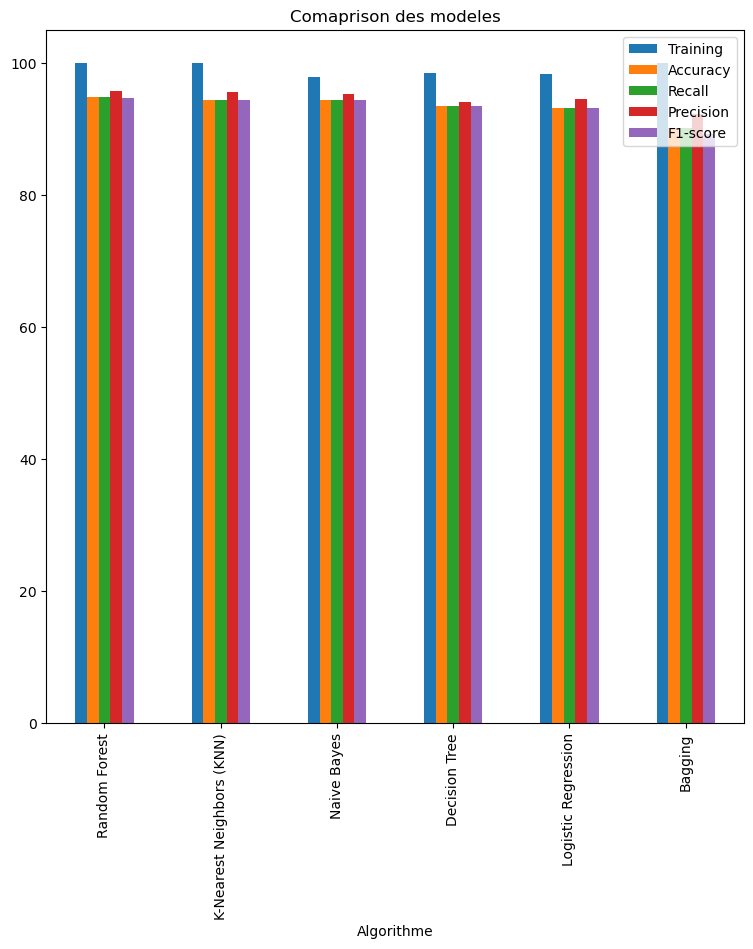

In [46]:
results = pd.DataFrame(results,index=index)
results = results.sort_values(by='Accuracy',ascending=False)
fig =results.plot(kind='bar',title='Comaprison des modeles',figsize =(9,9)).get_figure()
fig.savefig('Final Result.png')

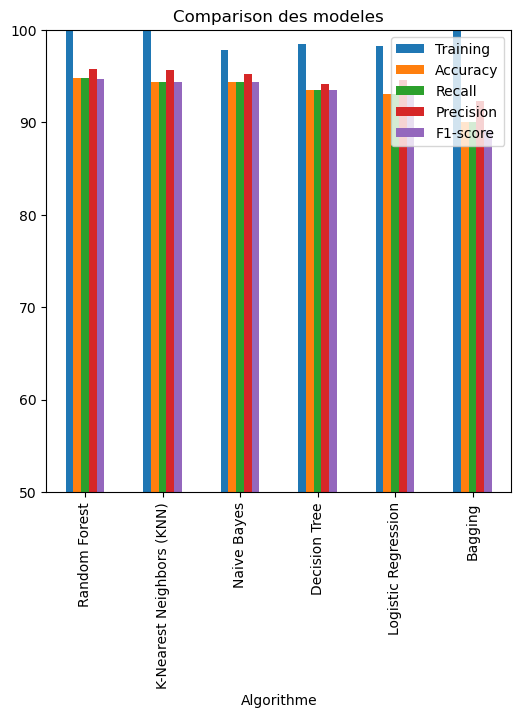

In [47]:
fig =results.plot(kind='bar',title='Comparison des modeles',figsize =(6,6),ylim=[50,100]).get_figure()
fig.savefig('image.png')

array([<Axes: title={'center': 'Training'}, xlabel='Algorithme'>,
       <Axes: title={'center': 'Accuracy'}, xlabel='Algorithme'>,
       <Axes: title={'center': 'Recall'}, xlabel='Algorithme'>,
       <Axes: title={'center': 'Precision'}, xlabel='Algorithme'>,
       <Axes: title={'center': 'F1-score'}, xlabel='Algorithme'>],
      dtype=object)

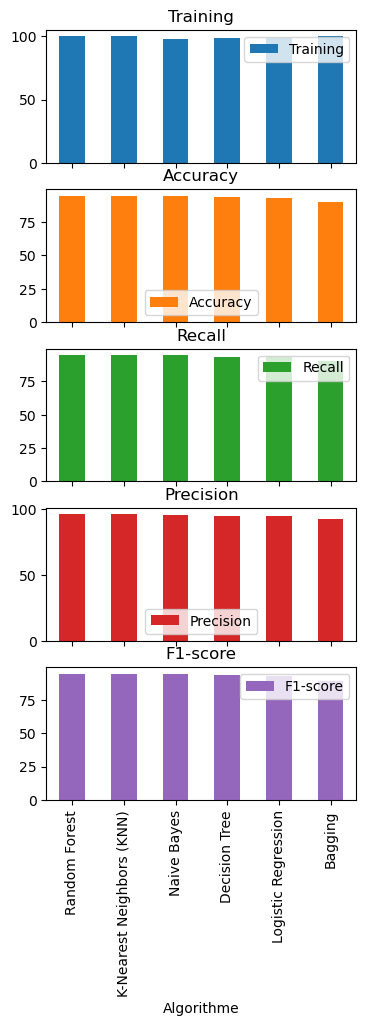

In [48]:
results.plot(subplots=True,kind ='bar',figsize=(4,10))

## Matrice de confusion

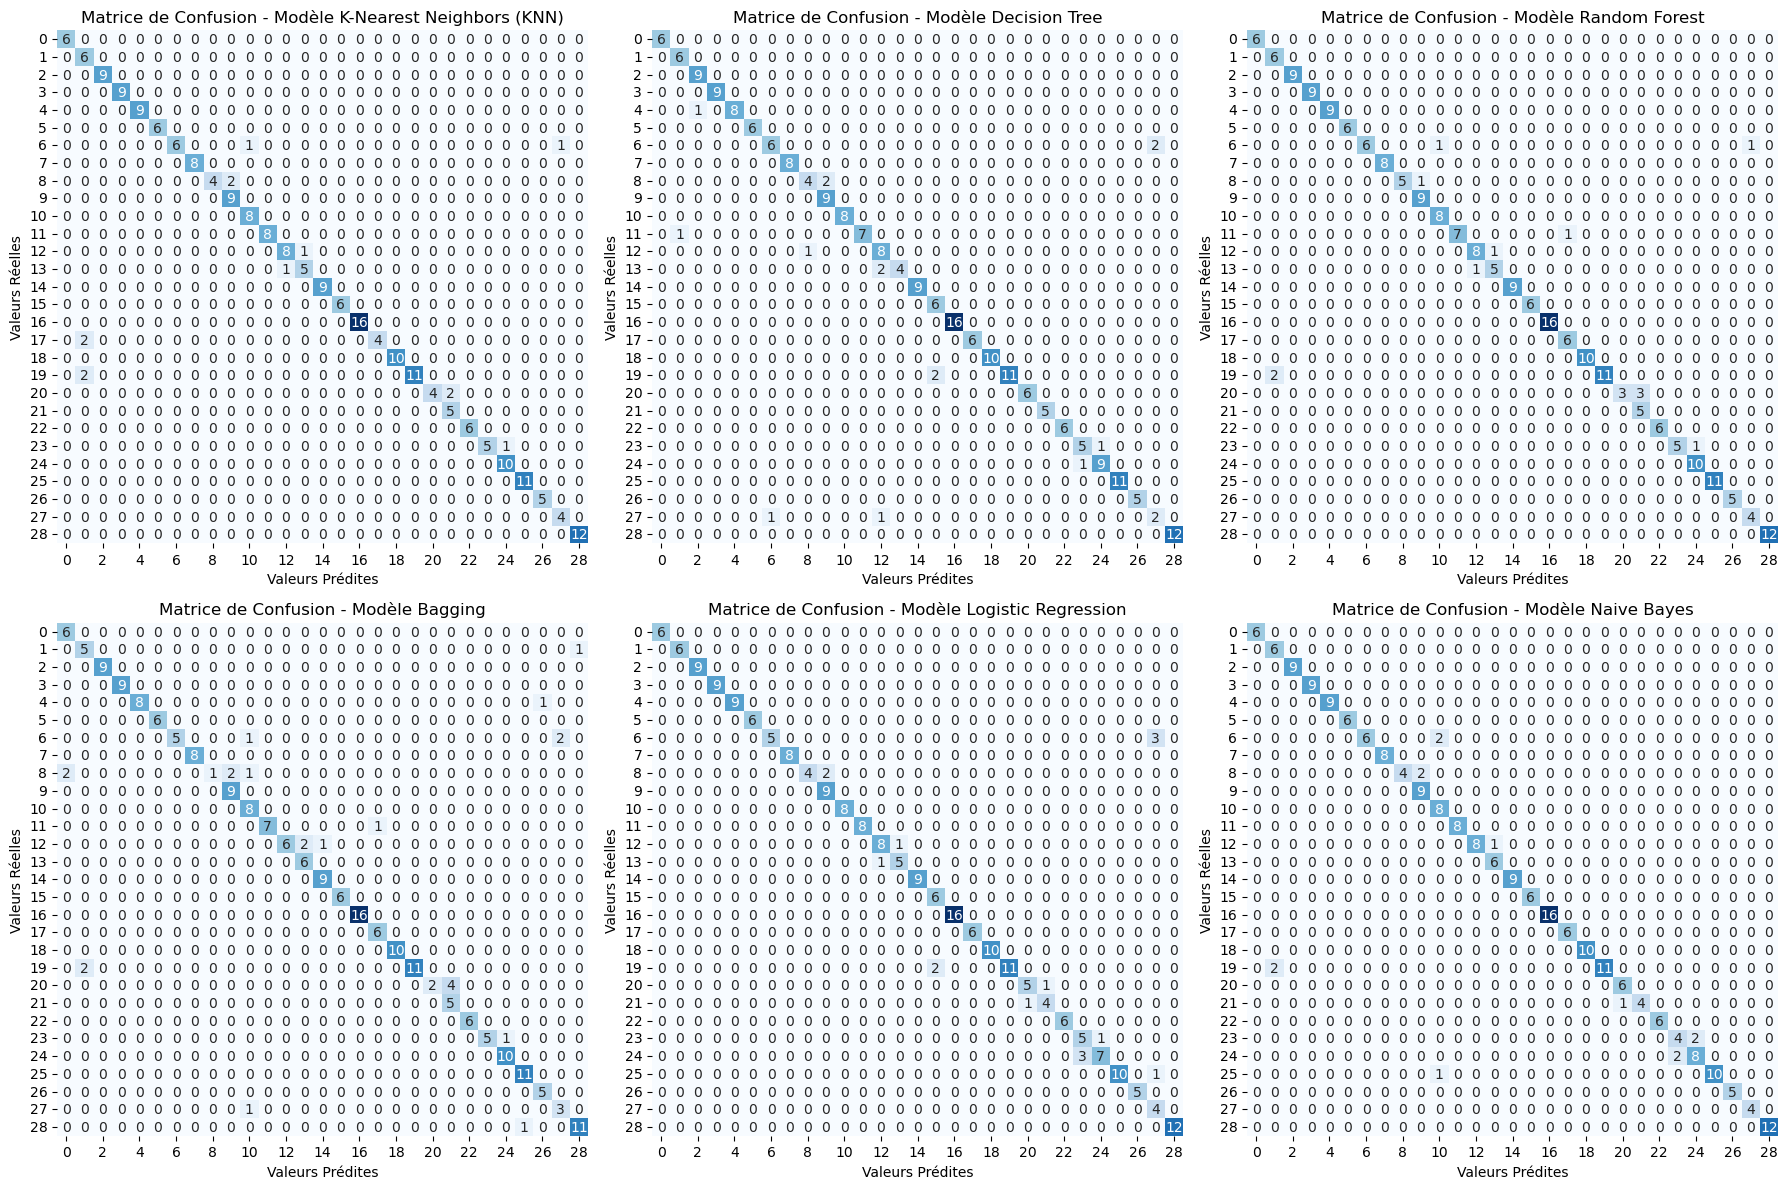

In [49]:

# Affichage des heatmaps des matrices de confusion pour chaque modèle
plt.figure(figsize=(18, 12))
for i, cm in enumerate(confusion_matrices, 1):
    plt.subplot(2, 3, i)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Matrice de Confusion - Modèle {index[i-1]}")
    plt.xlabel("Valeurs Prédites")
    plt.ylabel("Valeurs Réelles")

plt.tight_layout()
plt.show()

# Enregistrement des models dans des fichiers

In [60]:
from diseases_prediction_model import DiseasesPredictionModel


In [61]:
# save the models to disk
repertoire_sauvegarde = "/Users/maestro/Documents/Data_science_books/stage_master_ginfo_cloud/modele_prediction/"
normalizer = scaler
encoder_dict = {
    'Sexe': encoder_sexe,
    'Symptome_5': encoder_symptome_5,
    'Symptome_4': encoder_symptome_4,
    'Symptome_3': encoder_symptome_3,
    'Symptome_2': encoder_symptome_2,
    'Symptome_1': encoder_symptome_1,
    'Pathologie': encoder_pathologie
}
for i in range(0,len(model_search)):
    model= model_search['model_al'][i]
    save_model = DiseasesPredictionModel(model,encoder_dict,normalizer)
    nom_fichier = f'modele_{index[i]}.joblib'
    chemin_complet = repertoire_sauvegarde + nom_fichier
    joblib.dump(save_model, chemin_complet)


# Test de predictions en rechargant les models stocker

In [62]:
algorithmes = ["K-Nearest Neighbors (KNN)","Decision Tree","Random Forest","Bagging","Logistic Regression","Naive Bayes"]
models={}
for al in algorithmes:
    current_file = f'modele_{al}.joblib'
    chemin_complet = repertoire_sauvegarde + nom_fichier
    modele_charge = joblib.load(chemin_complet)
    models.__setitem__(al,modele_charge)

In [73]:
exemple = {
    "Age (en mois)" : 420,	
    "Sexe" : "M",
    "Poids (kg)" : 80,	
    "Symptome_5" : "Aucun",		
    "Symptome_4" : "Aucun",	
    "Symptome_3" : "Fièvre",	
    "Symptome_2" : "Sueurs",	
    "Symptome_1" : "Douleurs",
    }

In [74]:
classes_pred=[]
probas_pred=[]

for algo, model in models.items():
    classe,proba = model.predict_disease(exemple)
    if classe:
        # print(f'Selon le model {algo} le patient a : {classe} avec une probabilite de {proba*100}%')
        classes_pred.append(classe)
        probas_pred.append(proba)
    else:
        print("Données non valides.")
            
resultats_predictions = pd.DataFrame({"Algorithme": algorithmes, "Pathologie prédite": classes_pred, "Probabilités" : probas_pred})


/Users/maestro/Documents/Data_science_books/stage_master_ginfo_cloud/modele_prediction/diseases_prediction_model.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[prev_mod] = enc_data
/Users/maestro/Documents/Data_science_books/stage_master_ginfo_cloud/modele_prediction/diseases_prediction_model.py:28: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[prev_mod] = enc_data
/Users/maestro/Documents/Data_science_books/stage_master_ginfo_cloud/modele_prediction/diseases_prediction_model.py:28: PerformanceWarning: DataFrame is h

In [75]:
resultats_predictions

,Algorithme,Pathologie prédite,Probabilités
0,K-Nearest Neighbors (KNN),Stomatite du scorbut,0.983624
1,Decision Tree,Stomatite du scorbut,0.983624
2,Random Forest,Stomatite du scorbut,0.983624
3,Bagging,Stomatite du scorbut,0.983624
4,Logistic Regression,Stomatite du scorbut,0.983624
5,Naive Bayes,Stomatite du scorbut,0.983624
